# Exemplo de Kernel de Processamento de Apenas uma Categoria

Como vimos no estudo preliminar, existem diversas categorias de produtos a serem estimadas nesse desafio. Nesse notebook iremos tentar usar NLP e XGBoost para processar e estimar o preco de uma categoria de produtos

In [1]:
import pandas as pd

train = pd.read_pickle("../data/output/train.pickle")
category_with_more_rows = train.groupby(['category_name']).count().sort_values(['train_id'], ascending=False).index[0]
df_category = train[(train.category_name == category_with_more_rows)]

print "'{0}', {1} Registros".format(category_with_more_rows,len(df_category))


'Women/Athletic Apparel/Pants, Tights, Leggings', 60177 Registros


Conseguimos separar uma categoria de produtos para testar o nosso algoritmo, vamos continuar com a analise das features.

In [2]:
df_train = df_category.sample(frac=0.7)
df_test = df_category[~df_category.train_id.isin(df_train.train_id)]

print "Train:{} Test:{}".format(len(df_train), len(df_test))

Train:42124 Test:18053


In [3]:
print "Valores Unique para item_condition em todas categorias:{}".format(str(train.item_condition_id.unique()))
print "Valores Unique para item_condition nessa categoria:{}".format(str(df_category.item_condition_id.unique()))
print "Valores Unique para brand_name:{}".format(str(len(df_category.brand_name.unique())))
print "Preco Medio: ${}".format(df_category.price.mean())

Valores Unique para item_condition em todas categorias:[3 1 2 4 5]
Valores Unique para item_condition nessa categoria:[3 1 4 2 5]
Valores Unique para brand_name:374
Preco Medio: $34.392733104


Verificamos acima a dimensionalidade das features: item_condition e brand_name

E calculamos o preco medio dos items

Vamos ver se o valor 1-5 do item_condition tem relacao linear com o preço?

In [4]:
%matplotlib inline
df_category.groupby(['item_condition_id']).price.mean().plot()

Como podemos ver, o item_condition tem relacao linear com o preco, entao podemos usar como esta. Agora temos q ver o desvio que cada "brand_name" gera no preco, para isso iremos criar um dicionario em que cada brand_name estara relacionado ao seu peso em relacao ao preco medio de cada item...

In [5]:
from itertools import islice

mean_price = df_category.price.mean()
mean_prices_per_brand= df_category.groupby('brand_name').price.mean()

price_difference_per_brand = {k:(mean_prices_per_brand.loc[k] / mean_price)  for k in mean_prices_per_brand.index}

list(islice(price_difference_per_brand.iteritems(), 10))


[('Ecko Red', 0.75597365063635114),
 ('Flexees', 0.36344887049824576),
 ('Rewind', 0.29075909639859659),
 ('Fila Sport', 0.42783124184364923),
 ('Columbia', 0.67843789159672541),
 ('Heart Soul', 0.47248353164771945),
 ('Tek Gear', 0.46257128972504002),
 ("Tilly's", 0.40706273495803524),
 ('Too Fast', 0.69782183135663178),
 ("Joe's Jeans", 0.74143569581642133)]

Otimo, agora temos o desvio de cada brand_name em cada item, agora podemos montar as matrizes de treinamento, em primeiro lugar, devemos adicionar ao dataframe do pandas a variacao dada pelo brand a media de preco.

In [6]:
df_train['brand_variation']= df_train.apply(lambda row: price_difference_per_brand[row['brand_name']] if pd.notnull(row['brand_name']) else 1 , axis=1)
df_test['brand_variation']= df_test.apply(lambda row: price_difference_per_brand[row['brand_name']] if pd.notnull(row['brand_name']) else 1 , axis=1)

/home/gbencke/git/mercari/env/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Agora temos todos os dados no dataframe, vamos criar o dataframe de features e o de alvo.

As features sao: item_condition, brand_variation e shipping
O Alvo é: price

Criamos entao arrays de numpy para transportar para o algoritmo

In [7]:
train_matrix_x = df_train[['item_condition_id', 'brand_variation', 'shipping']].as_matrix()
test_matrix_x = df_test[['item_condition_id', 'brand_variation', 'shipping']].as_matrix()

train_matrix_y = df_train[['price']].as_matrix()
test_matrix_y = df_test[['price']].as_matrix()

Vamos entao treinar o nosso modelo, usando gradient boosting...

In [8]:
import xgboost 

# fit model no training data
model = xgboost.XGBClassifier(silent=True, max_depth=5)
model.fit(train_matrix_x, train_matrix_y.ravel())

/home/gbencke/git/mercari/env/local/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

Vamos mostrar um grafo da arvore de decisao montada pelo XGBoost

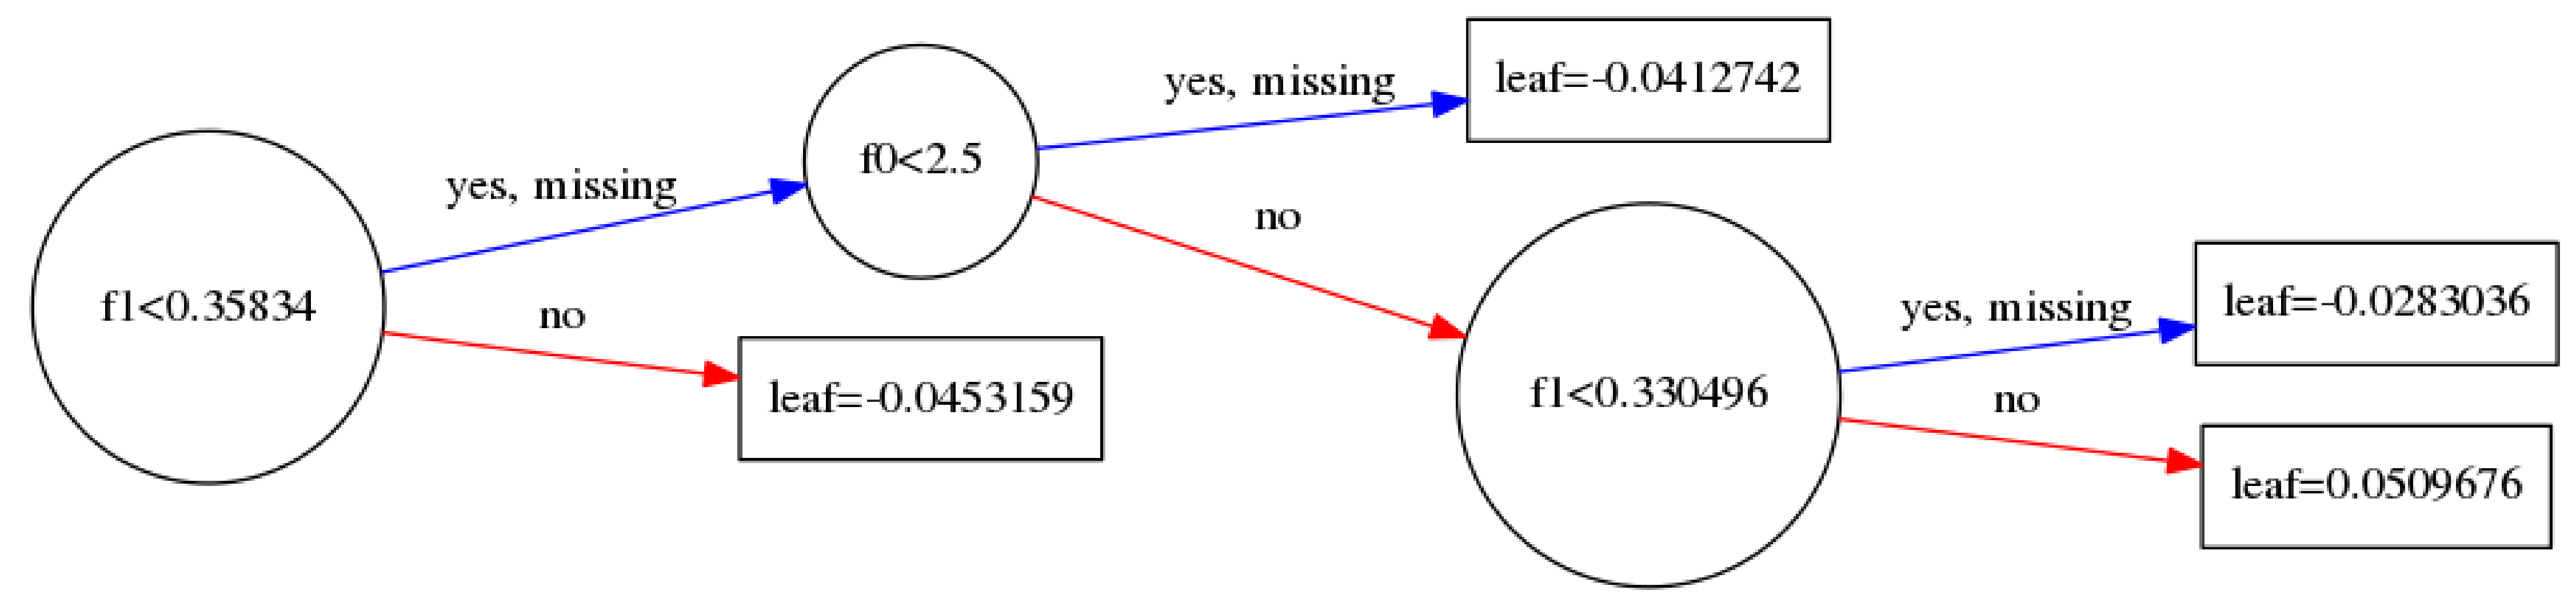

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from xgboost import plot_tree

rcParams['figure.figsize'] = 80,50

plot_tree(model, rankdir='LR')
plt.show()

E medir a performance do nosso modelo...

In [11]:
from sklearn.metrics import accuracy_score

test_y_pred = model.predict(test_matrix_x)
test_predictions = [value for value in test_y_pred]
print "Rows on test:{} - {}".format(len(test_predictions), len(test_matrix_y))
accuracy = accuracy_score(test_matrix_y, test_predictions)
print("Accuracy on test : %.2f%%" % (accuracy * 100.0))

Rows on test:18053 - 18053
Accuracy on test : 8.52%


Podemos verificar abaixo a matriz enviada para o XGBoost para predicao, interessante q ele traça um valor fixo e dai na arvore ele aumenta ou diminiu do valor alvo para gerar a predicao. No nosso caso o centro é 40.

In [12]:
print "Features:", test_matrix_x[:10]
print "Alvo:", test_matrix_y[:10]

print "Predicoes", test_y_pred[:10]

Features: [[ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [ 4.          0.71743324  0.        ]
 [ 2.          0.90292778  0.        ]
 [ 1.          1.          1.        ]
 [ 1.          1.          1.        ]
 [ 3.          0.9360306   0.        ]
 [ 1.          1.05654449  0.        ]
 [ 2.          1.          0.        ]]
Alvo: [[ 50.]
 [ 13.]
 [ 38.]
 [ 25.]
 [ 20.]
 [ 40.]
 [ 30.]
 [  9.]
 [ 44.]
 [ 18.]]
Predicoes [ 40.  40.  40.  14.  24.  40.  40.  19.  29.  24.]
